#### Import Statements

In [1]:
%matplotlib inline
%env IONQ_API_KEY= UHwrJdgGZCyf2U6DB8SE24YBFTB0dpep 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import qiskit
import qiskit.providers.aer.noise as noise

import collections
import pennylane as qml

import pennylane as qml
import torch
from torch.autograd.functional import hessian, jacobian
import pennylane_ionq as ionq
from pennylane_ionq import ops # not used right now, but for future
from pennylane import numpy as np # autograd compatible numpy
from pennylane.numpy import pi 
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
%precision %0.4f   
#control display precision

if True:    #for collapsing following block in Spyder or any editor
    import seaborn as sns
    
    sns.set_color_codes("deep"); sns.set_context("paper"); sns.set_style("ticks")
    STYLE_DICT = dict.fromkeys(['axes.labelsize', 'xtick.labelsize', 'ytick.labelsize', 'axes.titlesize'], 'medium')
    STYLE_DICT.update({'font.size': 18, 'figure.dpi':150, 'image.cmap': 'plasma'})
    STYLE_DICT.update(dict.fromkeys(['ytick.direction', 'xtick.direction'], 'in'))
    STYLE_DICT.update(dict.fromkeys(['xtick.major.width', 'ytick.major.width', 'axes.linewidth'], .5))
    plt.rcParams.update(STYLE_DICT)

env: IONQ_API_KEY=UHwrJdgGZCyf2U6DB8SE24YBFTB0dpep


#### Required Inputs

In [11]:
num_wires = 5
num_layers = 3

'''***CHOOSE QC OR SIM***'''

#When running on simulator
backend_choice = "ionq.simulator" #change to what backend (classical or real computer)
noise_model = "aria-1"

#When running on QC
backend_provider = "ionq.qpu"
target_computer = "qpu.aria-1"

#Devices
#devExact = qml.device(backend_provider, wires=num_wires, target=target_computer, shots=1000)
devExact = ionq.SimulatorDevice(target="simulator.aria-1", wires=num_wires, shots=1000)
#devParametrized = qml.device(backend_provider, wires=num_wires, target=target_computer, shots=1000)
devParametrized = ionq.SimulatorDevice(target="simulator.aria-1", wires=num_wires, shots=1000)

'''*********************'''

#optimized thetas for circuit
IPG_array = np.pi*np.array([ 0.1071, -0.3914,  0.5013,  0.0598,  0.4906, -0.4649,  0.1848,  0.0028,
        -0.2141, -0.2075,  0.0034,  0.7484,  0.0467,  0.0286,  0.0455, -0.0377,
         0.3938,  0.2077, -0.3087,  0.0025, -0.3300, -0.2116, -0.0062, -0.1510,
         0.4248, -0.0046,  0.1098,  0.0440,  0.0252,  0.2110, -0.1711, -0.0055,
        -0.6632, -0.0363, -0.0107, -0.2127, -0.1964, -0.0118,  0.0300,  0.5177,
         0.0044, -0.3690,  0.2098,  0.0030,  0.1325])

#### Helper Functions

In [12]:
#circuit unitary
dev = qml.device("default.qubit", wires=num_wires)
param_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_wires)
weights = torch.rand(param_shape)

def fidelity(cur_state, target_state): # Inner product 
    return torch.real(torch.dot(torch.conj(cur_state), target_state))

def norm(state): # normalize 
    return state / torch.sqrt((torch.dot(torch.conj(state), state)))

def phi_parameterization(params): # restrict phase angles to -pi to pi
    return torch.clip(params, -1.5*pi, 1.5*pi) #np is okay since the params input should be a pytorch array

# @qml.qnode(dev, interface='torch', diff_method="backprop")
def unitary_random_layers_no_noise(array):
    return qml.StronglyEntanglingLayers(weights=phi_parameterization(array.reshape(param_shape)), wires=range(N_wires))

def unitary_result(array):
    # op = unitary_random_layers_no_noise(array)
    # matrix = qml.matrix(op)
    # matrix_torch = torch.tensor(matrix, dtype=torch.complex128, requires_grad=True)
    matrix_torch = qml.matrix(qml.StronglyEntanglingLayers(weights=phi_parameterization(array.reshape(param_shape)), wires=range(N_wires)))
    return matrix_torch

#fidelity between target matrix and unitary
def matrix_fidelity(mat1, mat2):
    squared = mod_squared(torch.sub(mat1, mat2))
    summed = torch.sum(squared)
    #float_val = extract_float(summed)
    return summed

#helper functions
def mod_squared(mat):
    if mat.dtype == torch.complex64 or mat.dtype == torch.complex128:
        real_part = mat.real
        imag_part = mat.imag    
        # return torch.tensor(torch.pow(real_part, 2) + torch.pow(imag_part, 2))
        return real_part**2 + imag_part**2
    else:
        # return torch.pow(mat, 2)
        return mat**2

def extract_float(tensor):
    if tensor.numel() == 1:
        float_value = tensor.item()
        return float_value

def inner_product(vector1, vector2): #for column vectors
    return torch.matmul(torch.conj(vector1.T), vector2).item()

def random_state(N_qubits):
    entries = 2**N_qubits
    rand_column = torch.rand(entries, 1, dtype=torch.complex128)
    norm_factor = torch.sum(torch.abs(rand_column)**2)
    normalized_rand_column = rand_column/torch.sqrt(norm_factor)
    return normalized_rand_column

def get_circuit_matrix(phi_array): #this is for NON gradient purposes
    circuit = torch.tensor(unitary_result(phi_array).clone().detach(), dtype=torch.complex128)
    return circuit

def get_statevector(matrix, column_vector):
    result = torch.matmul(matrix, column_vector)
    return result

def phys_dot(vectorA, vectorB): #computes dot product after taking the complex conjugate of one vector
    outputA = np.conjugate(vectorA)
    result = np.dot(outputA, vectorB)
    return result

def get_global_phase(vectorA, vectorB):
    complexVal = phys_dot(vectorA, vectorB)
    outputReal = np.abs(np.arccos(np.abs(complexVal.real)))
    outputImag = np.abs(np.arcsin(np.abs(complexVal.imag)))
    print(outputReal, "real")
    print(outputImag, "imag")
    print("thetas for real and imaginary part differ by: ", outputReal - outputImag, " radians")
    print("Global Phase: ")
    return outputReal

def selectBasis(value):
    if value == 0:
        return qml.BasisState([1.0, 0.0, 0.0], wires=range(num_wires))
    elif value == 1:
        return qml.BasisState([0.0, 1.0, 0.0], wires=range(num_wires))
    elif value == 2:
        return qml.BasisState([0.0, 0.0, 1.0], wires=range(num_wires))
    else:
        print("function only built for 3 qubits currently, please modify for more")

def selectBasis(value):
    if value == 0:
        return [0] * num_wires

    binary_list = []
    while value > 0:
        remainder = value % 2
        binary_list.insert(0, remainder)
        value //= 2

    while len(binary_list) < num_wires:
        binary_list.insert(0, 0)
    
    print(binary_list)
    return binary_list

#### Circuits

- Check if Ideal Function from Pennylane Works

In [46]:
@qml.qnode(devExact)
def exactCircuit(value):
    #selectBasis(value)
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.Hadamard(2)
    qml.PauliZ(2)
    qml.QFT(wires=range(num_wires))
    return qml.probs(wires=[0,1,2])
    #return qml.state()
#exactCircuit(0)

- parametrized circuit below

In [13]:
@qml.qnode(devParametrized)
def paramCircuit(parameters, value):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(num_wires))
    return qml.probs(wires=[0,1,2])
    #return qml.state()
#phys_dot(paramCircuit(IPG_array.reshape(param_shape), 0), exactCircuit(0))

#### Plotting
- comment out if doing QPU runs

In [25]:
# ******** COMMENT OUT IF DOING QPU RUNS ******** * 

'''exact_state = exactCircuit()
exact_real = np.copy(exact_state.real)
exact_imag = np.copy(exact_state.imag)

IPG_param_state = paramCircuit(IPG_array.reshape(param_shape))
IPG_param_state_real = np.copy(IPG_param_state.real)
IPG_param_state_imag = np.copy(IPG_param_state.imag)'''


'exact_state = exactCircuit()\nexact_real = np.copy(exact_state.real)\nexact_imag = np.copy(exact_state.imag)\n\nIPG_param_state = paramCircuit(IPG_array.reshape(param_shape))\nIPG_param_state_real = np.copy(IPG_param_state.real)\nIPG_param_state_imag = np.copy(IPG_param_state.imag)'

In [26]:
'''plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.yticks(va='center')
plt.xticks(va='center')
plt.tick_params(axis='y', pad=-2)
plt.tick_params(axis='x', pad=7)
sns.set_style("darkgrid")
sns.scatterplot(x=exact_real, y=exact_imag, s=100, label='exact solution')
plt.axhline(0, color='red')
plt.axvline(0, color='red')
plt.show()'''

'plt.xlabel("Real")\nplt.ylabel("Imaginary")\nplt.yticks(va=\'center\')\nplt.xticks(va=\'center\')\nplt.tick_params(axis=\'y\', pad=-2)\nplt.tick_params(axis=\'x\', pad=7)\nsns.set_style("darkgrid")\nsns.scatterplot(x=exact_real, y=exact_imag, s=100, label=\'exact solution\')\nplt.axhline(0, color=\'red\')\nplt.axvline(0, color=\'red\')\nplt.show()'

In [27]:
'''print("Imaginary", IPG_param_state_imag)
print("Real", IPG_param_state_real)
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.yticks(va='center')
plt.xticks(va='center')
plt.tick_params(axis='y', pad=-2)
plt.tick_params(axis='x', pad=7)
sns.set_style("darkgrid")
sns.scatterplot(x=IPG_param_state_real, y=IPG_param_state_imag, s=100, color='green', label='IPG')
plt.axhline(0, color='red')
plt.axvline(0, color='red')'''

'print("Imaginary", IPG_param_state_imag)\nprint("Real", IPG_param_state_real)\nplt.xlabel("Real")\nplt.ylabel("Imaginary")\nplt.yticks(va=\'center\')\nplt.xticks(va=\'center\')\nplt.tick_params(axis=\'y\', pad=-2)\nplt.tick_params(axis=\'x\', pad=7)\nsns.set_style("darkgrid")\nsns.scatterplot(x=IPG_param_state_real, y=IPG_param_state_imag, s=100, color=\'green\', label=\'IPG\')\nplt.axhline(0, color=\'red\')\nplt.axvline(0, color=\'red\')'

In [28]:
#get_global_phase(IPG_param_state, exact_state)

#### Running on actual comp or comp sim

- running parametrized circuit on 

Basis [1,0,0] Counter({0: 0.42199999999999993, 7: 0.37799999999999995, 1: 0.04099999999999999, 6: 0.039999999999999994, 2: 0.033999999999999996, 5: 0.03299999999999999, 3: 0.026999999999999993, 4: 0.024999999999999994})


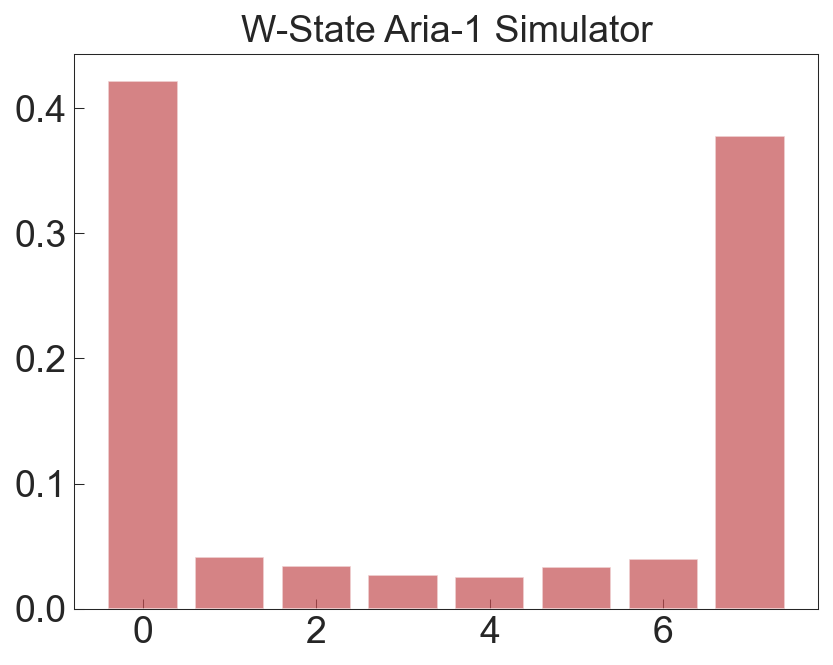

Param Basis [0,1,0] Counter({7: 0.4069999999999999, 0: 0.38799999999999996, 6: 0.045999999999999985, 1: 0.041999999999999996, 5: 0.03699999999999999, 4: 0.032999999999999995, 2: 0.028999999999999995, 3: 0.017999999999999995})


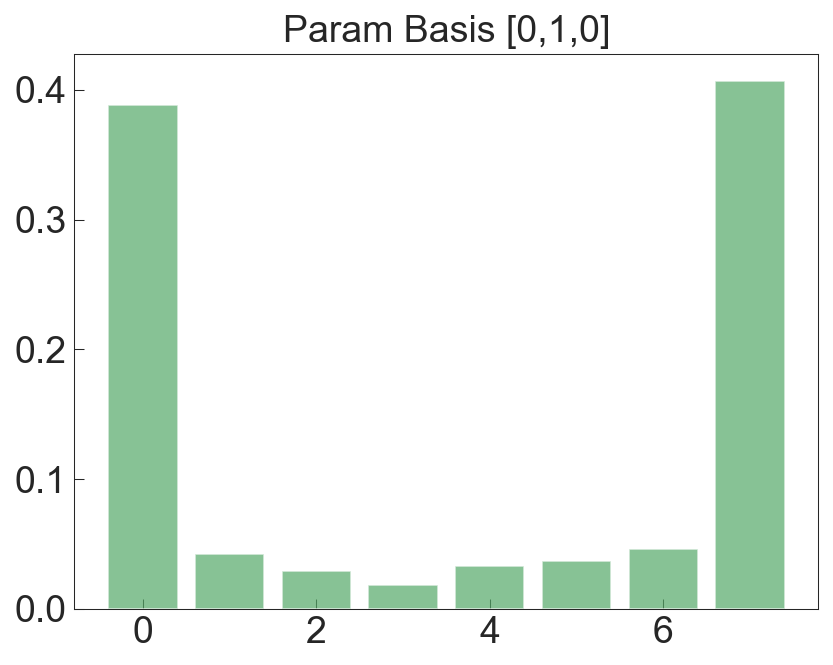

Basis [0,0,1] Counter({7: 0.4169999999999999, 0: 0.36499999999999994, 2: 0.051999999999999984, 6: 0.04399999999999999, 5: 0.043, 1: 0.036999999999999984, 3: 0.020999999999999994, 4: 0.020999999999999994})


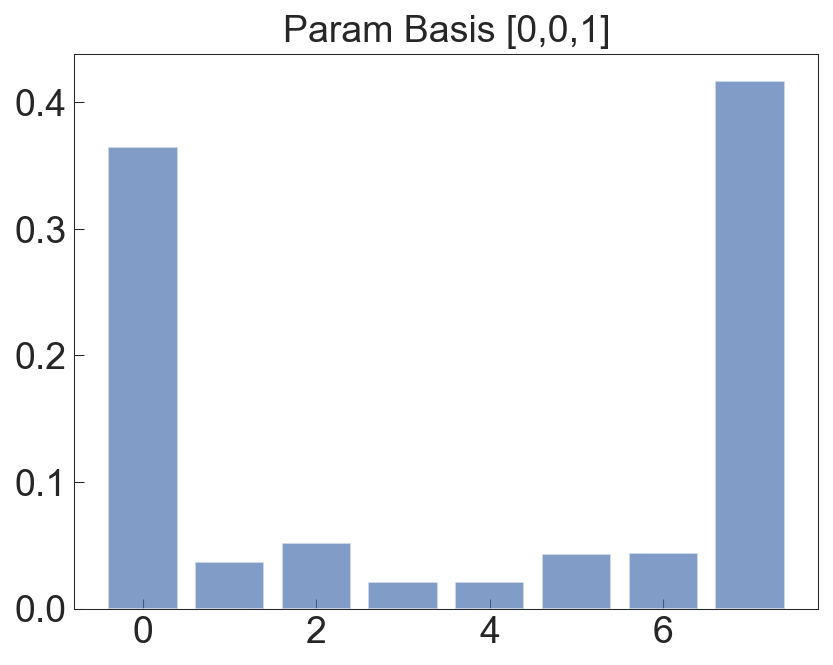

In [14]:
resultsParamBasis0 = collections.Counter(dict(enumerate(paramCircuit(IPG_array.reshape(param_shape), 0))))
print("Basis [1,0,0]", resultsParamBasis0)
keys0 = list(resultsParamBasis0.keys())
values0 = [value.item() for value in resultsParamBasis0.values()]
plt.title("W-State Aria-1 Simulator")
plt.bar(keys0, values0, align='center', alpha=0.7, color='r')
plt.show()

resultsParamBasis1 = collections.Counter(dict(enumerate(paramCircuit(IPG_array.reshape(param_shape), 1))))
print("Param Basis [0,1,0]", resultsParamBasis1)
keys1 = list(resultsParamBasis1.keys())
values1 = [value.item() for value in resultsParamBasis1.values()]
plt.title("Param Basis [0,1,0]")
plt.bar(keys1, values1, align='center', alpha=0.7, color='g')
plt.show()

resultsParamBasis2 = collections.Counter(dict(enumerate(paramCircuit(IPG_array.reshape(param_shape), 2))))
print("Basis [0,0,1]", resultsParamBasis2)
keys2 = list(resultsParamBasis2.keys())
values2 = [value.item() for value in resultsParamBasis2.values()]
plt.title("Param Basis [0,0,1]")
plt.bar(keys2, values2, align='center', alpha=0.7, color='b')
plt.show()

Basis [1,0,0] Counter({4: tensor(0.912, requires_grad=True), 0: tensor(0.027, requires_grad=True), 5: tensor(0.024, requires_grad=True), 1: tensor(0.016, requires_grad=True), 2: tensor(0.011, requires_grad=True), 6: tensor(0.009, requires_grad=True), 3: tensor(0.001, requires_grad=True), 7: tensor(0., requires_grad=True)})


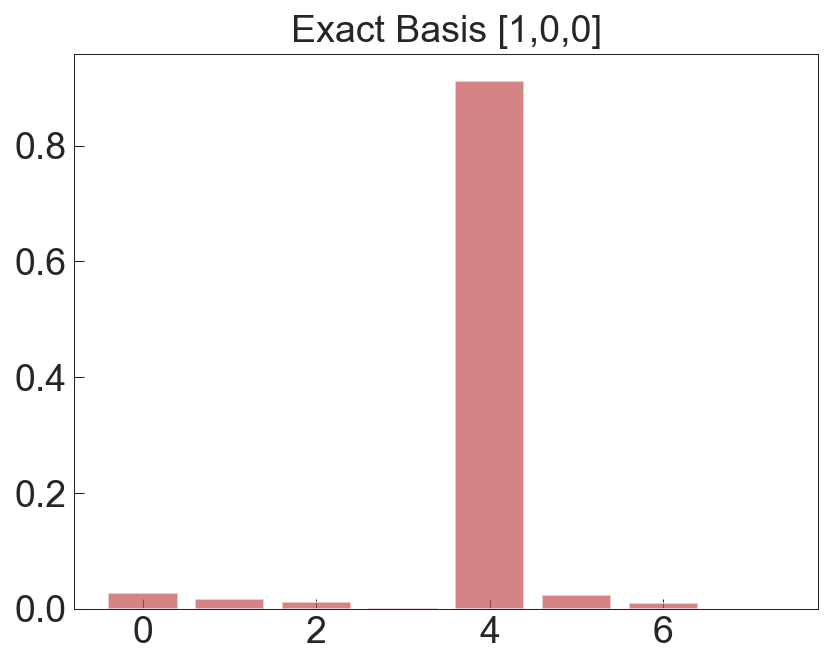

Basis [0,1,0] Counter({4: tensor(0.922, requires_grad=True), 0: tensor(0.036, requires_grad=True), 5: tensor(0.017, requires_grad=True), 1: tensor(0.011, requires_grad=True), 2: tensor(0.009, requires_grad=True), 6: tensor(0.003, requires_grad=True), 3: tensor(0.002, requires_grad=True), 7: tensor(0., requires_grad=True)})


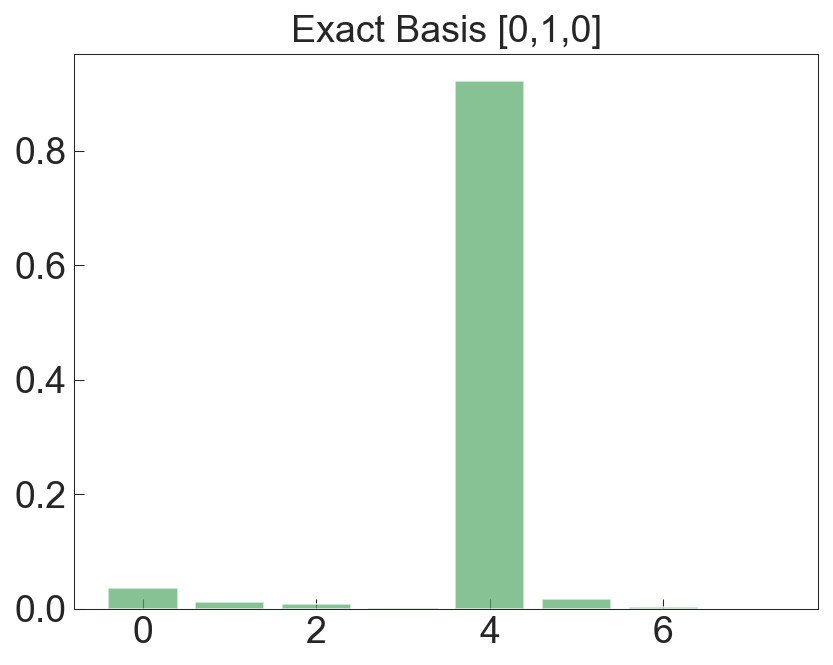

Basis [0,0,1] Counter({4: tensor(0.911, requires_grad=True), 0: tensor(0.036, requires_grad=True), 1: tensor(0.019, requires_grad=True), 5: tensor(0.015, requires_grad=True), 6: tensor(0.009, requires_grad=True), 2: tensor(0.008, requires_grad=True), 3: tensor(0.001, requires_grad=True), 7: tensor(0.001, requires_grad=True)})


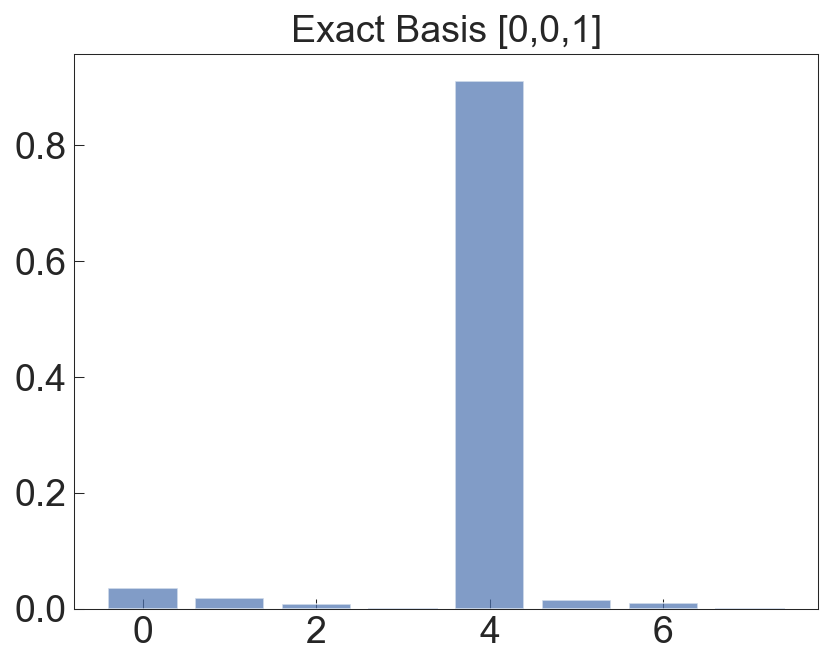

In [30]:
resultsParamBasis0_Exact = collections.Counter(dict(enumerate(exactCircuit(0))))
print("Basis [1,0,0]", resultsParamBasis0_Exact)
keys0_Exact = list(resultsParamBasis0_Exact.keys())
values0_Exact = [value.item() for value in resultsParamBasis0_Exact.values()]
plt.title("Exact Basis [1,0,0]")
plt.bar(keys0_Exact, values0_Exact, align='center', alpha=0.7, color='r')
plt.show()

resultsParamBasis1_Exact = collections.Counter(dict(enumerate(exactCircuit(1))))
print("Basis [0,1,0]", resultsParamBasis1_Exact)
keys1_Exact = list(resultsParamBasis1_Exact.keys())
values1_Exact = [value.item() for value in resultsParamBasis1_Exact.values()]
plt.title("Exact Basis [0,1,0]")
plt.bar(keys1_Exact, values1_Exact, align='center', alpha=0.7, color='g')
plt.show()

resultsParamBasis2_Exact = collections.Counter(dict(enumerate(exactCircuit(2))))
print("Basis [0,0,1]", resultsParamBasis2_Exact)
keys2_Exact = list(resultsParamBasis2_Exact.keys())
values2_Exact = [value.item() for value in resultsParamBasis2_Exact.values()]
plt.title("Exact Basis [0,0,1]")
plt.bar(keys2_Exact, values2_Exact, align='center', alpha=0.7, color='b')
plt.show()

In [2]:
QFT = {
  "0": 0.015,
  "1": 0.211,
  "2": 0.126,
  "3": 0.015,
  "4": 0.194,
  "5": 0.013,
  "6": 0.006,
  "7": 0.039,
  "8": 0.281,
  "9": 0.015,
  "10": 0.009,
  "11": 0.01,
  "12": 0.015,
  "13": 0.017,
  "14": 0.025,
  "15": 0.009
}
diction = {
  "0": 0.012,
  "1": 0.217,
  "2": 0.22,
  "3": 0.021,
  "4": 0.2,
  "5": 0.012,
  "6": 0.007,
  "7": 0.019,
  "8": 0.184,
  "9": 0.014,
  "10": 0.023,
  "11": 0.014,
  "12": 0.011,
  "13": 0.02,
  "14": 0.011,
  "15": 0.015
}

diction1 = {
  "0": 0.015,
  "1": 0.211,
  "2": 0.126,
  "3": 0.015,
  "4": 0.194,
  "5": 0.013,
  "6": 0.006,
  "7": 0.039,
  "8": 0.281,
  "9": 0.015,
  "10": 0.009,
  "11": 0.01,
  "12": 0.015,
  "13": 0.017,
  "14": 0.025,
  "15": 0.009
}



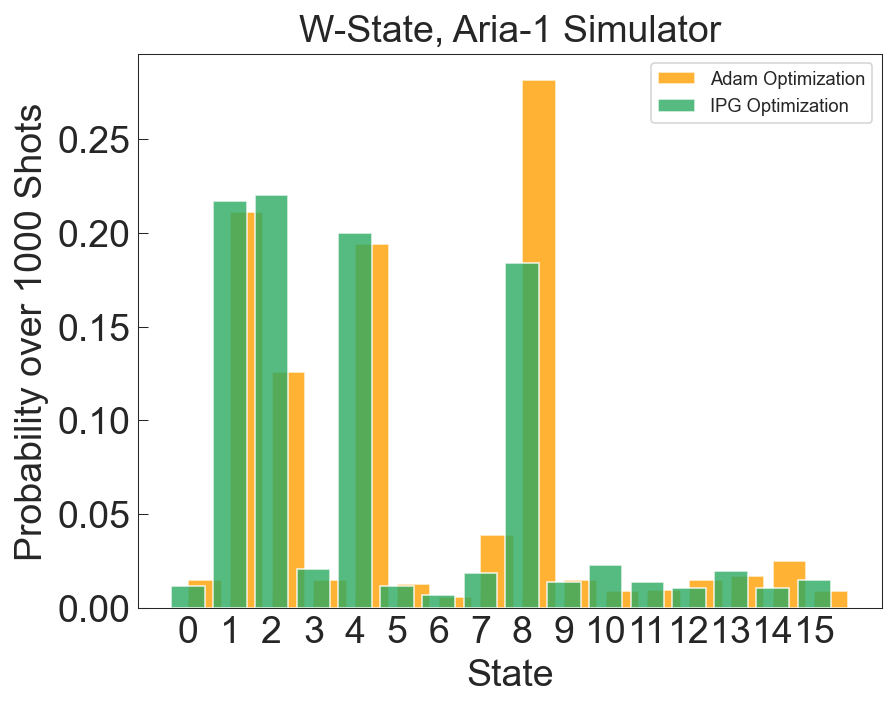

In [3]:

#plt.style.use('seaborn-deep')
plt.bar(QFT.keys(), QFT.values(), label="Adam Optimization", color="#ff9f00", alpha=0.8, align='edge')
plt.bar(diction.keys(), diction.values(), label="IPG Optimization", color="#2aaa61", alpha=0.8)
#plt.axhline(125, label="Exact Result", color="green")
plt.title("W-State, Aria-1 Simulator")
plt.xlabel("State")
plt.ylabel("Probability over 1000 Shots")
plt.legend()
plt.show()

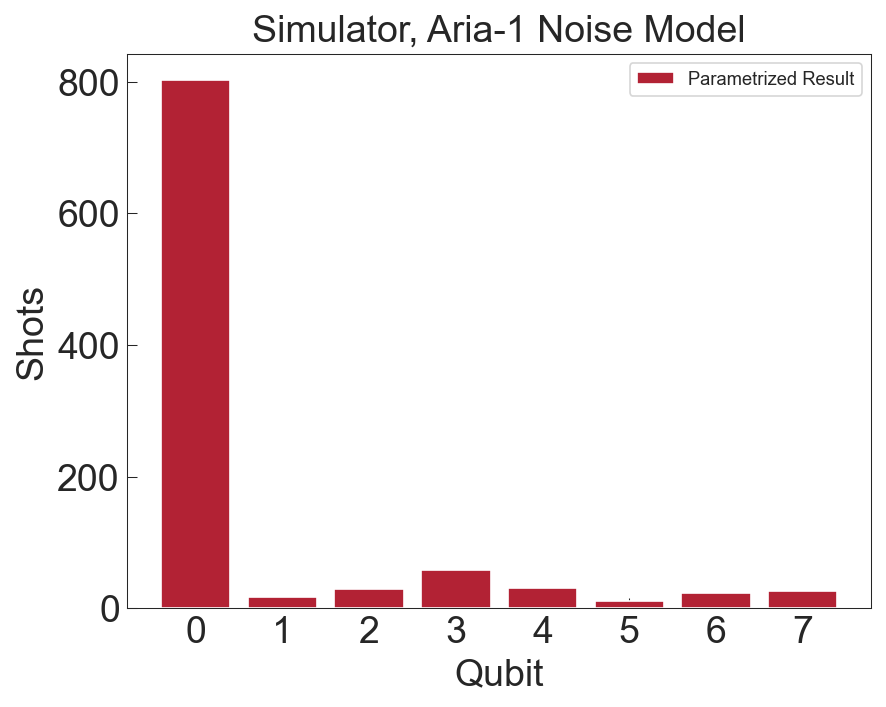

In [36]:
plt.bar(diction.keys(), diction.values(), label="Parametrized Result", color="#b22234")
#plt.bar(QFT.keys(), QFT.values(), label="QFT Result", color="#56b5a9", alpha=0.8)
#plt.axhline(125, label="Exact Result", color="green")
plt.title("Simulator, Aria-1 Noise Model")
plt.xlabel("Qubit")
plt.ylabel("Shots")
plt.legend()
plt.show()

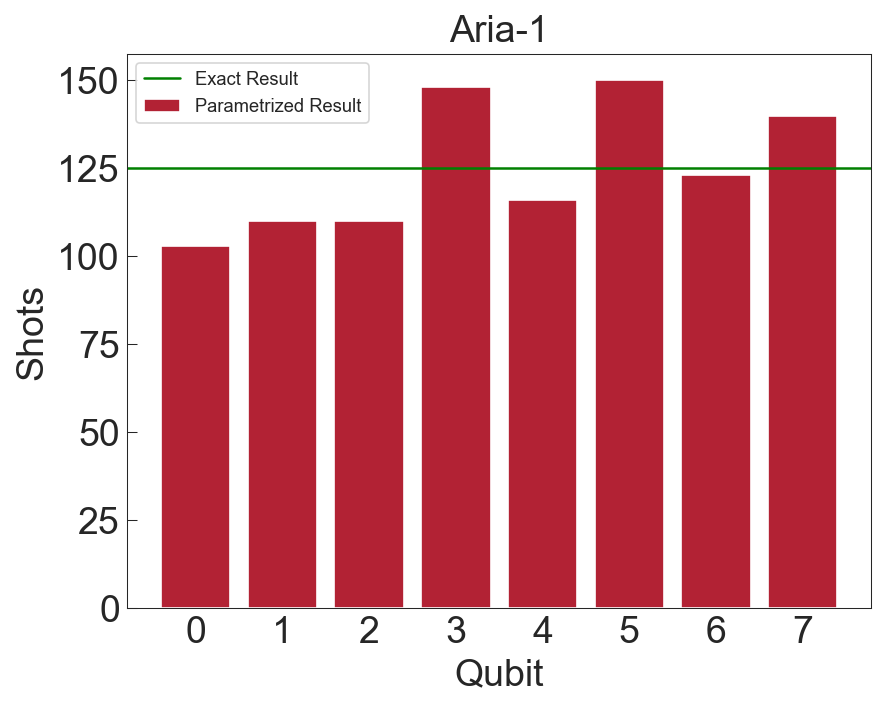

In [34]:
aria1 = {
  "0": 103,
  "1": 110,
  "2": 110,
  "3": 148,
  "4": 116,
  "5": 150,
  "6": 123,
  "7": 140
}

plt.bar(aria1.keys(), aria1.values(), label="Parametrized Result", color="#b22234")
plt.axhline(125, label="Exact Result", color="green")
plt.title("Aria-1")
plt.xlabel("Qubit")
plt.ylabel("Shots")
plt.legend()
plt.show()

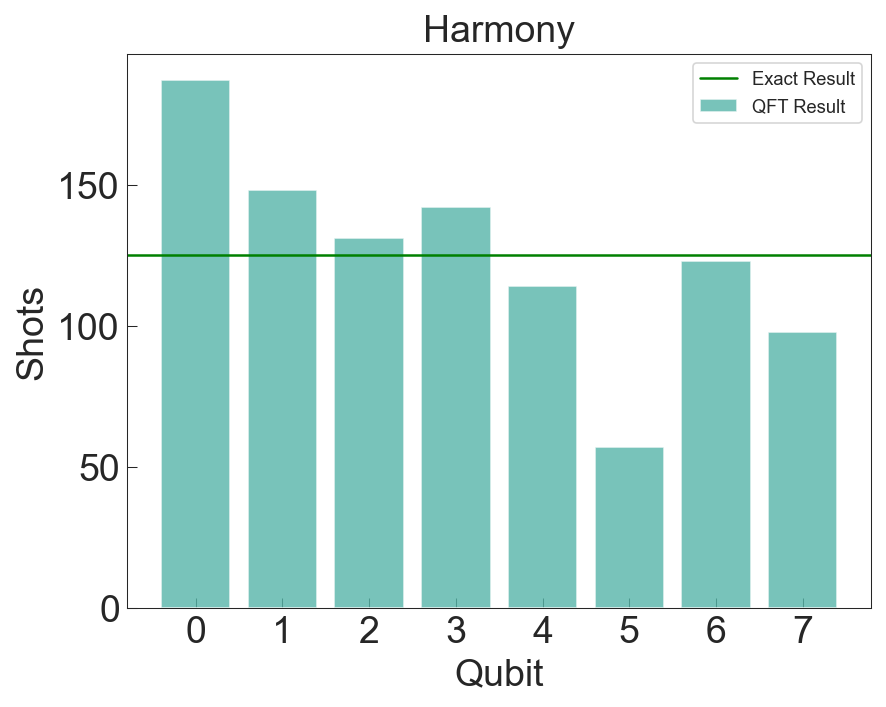

In [35]:
plt.bar(QFT.keys(), QFT.values(), label="QFT Result", color="#56b5a9", alpha=0.8)
plt.axhline(125, label="Exact Result", color="green")
plt.title("Harmony")
plt.xlabel("Qubit")
plt.ylabel("Shots")
plt.legend()
plt.show()

In [15]:
QFT = {
  "0": 0.398,
  "1": 0.013,
  "2": 0.016,
  "3": 0.004,
  "4": 0.011,
  "5": 0.001,
  "6": 0.001,
  "7": 0.014,
  "8": 0.006,
  "9": 0.007,
  "10": 0.01,
  "11": 0.016,
  "12": 0.006,
  "14": 0.001,
  "15": 0.002,
  "16": 0.002,
  "17": 0.004,
  "18": 0.001,
  "19": 0.009,
  "20": 0.019,
  "21": 0.008,
  "22": 0.009,
  "23": 0.006,
  "24": 0.016,
  "25": 0.001,
  "26": 0.007,
  "27": 0.011,
  "28": 0.005,
  "29": 0.024,
  "30": 0.016,
  "31": 0.356
}
diction = {
  "0": 0.402,
  "1": 0.015,
  "2": 0.019,
  "3": 0.002,
  "4": 0.008,
  "5": 0.001,
  "6": 0.006,
  "7": 0.009,
  "8": 0.002,
  "9": 0.003,
  "10": 0.006,
  "11": 0.011,
  "12": 0.004,
  "14": 0.004,
  "15": 0.004,
  "16": 0.003,
  "17": 0.007,
  "18": 0.001,
  "19": 0.003,
  "20": 0.019,
  "21": 0.008,
  "22": 0.005,
  "23": 0.004,
  "24": 0.008,
  "25": 0.003,
  "26": 0.002,
  "27": 0.011,
  "28": 0.006,
  "29": 0.015,
  "30": 0.018,
  "31": 0.391
}

diction1 = {
  "0": 0.015,
  "1": 0.211,
  "2": 0.126,
  "3": 0.015,
  "4": 0.194,
  "5": 0.013,
  "6": 0.006,
  "7": 0.039,
  "8": 0.281,
  "9": 0.015,
  "10": 0.009,
  "11": 0.01,
  "12": 0.015,
  "13": 0.017,
  "14": 0.025,
  "15": 0.009
}



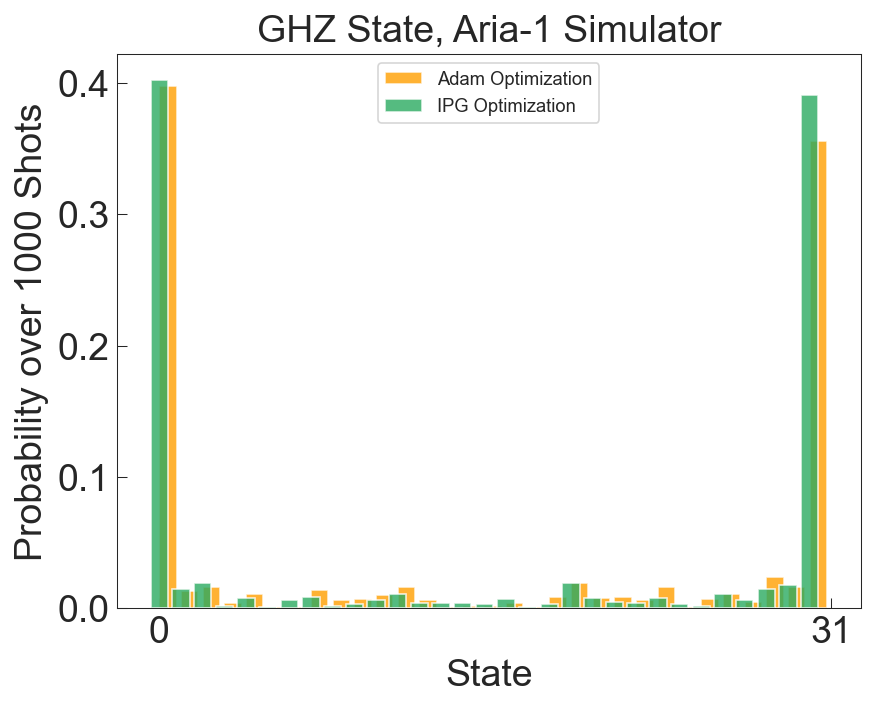

In [17]:

#plt.style.use('seaborn-deep')
plt.bar(QFT.keys(), QFT.values(), label="Adam Optimization", color="#ff9f00", alpha=0.8, align='edge')
plt.bar(diction.keys(), diction.values(), label="IPG Optimization", color="#2aaa61", alpha=0.8)
#plt.axhline(125, label="Exact Result", color="green")
plt.xticks([0, 31], ['0', '31'])
plt.title("GHZ State, Aria-1 Simulator")
plt.xlabel("State")
plt.ylabel("Probability over 1000 Shots")
plt.legend()
plt.show()